In [1]:
#####Note:run in python2######
# same initialization of weights because same random seed used

import math
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt 

#for shuffling data
from sklearn.utils import shuffle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

In [2]:
#########
#MLP

# initialisation of the weights he_normal
def weights(noHiddenLayers,sizeOfLayers):

    W=[]
    b=[]

    for i in range(0,noHiddenLayers+1):
        
        W.append( np.random.normal(1e-4,np.sqrt(2*1.0/(sizeOfLayers[i+1]+sizeOfLayers[i])),
                                   (sizeOfLayers[i+1],sizeOfLayers[i])) )
        b.append( np.random.normal(1e-4,np.sqrt(2*1.0/(sizeOfLayers[i+1]+1)),
                                   (sizeOfLayers[i+1],1)) )

    W=np.array(W)
    b=np.array(b)
    
    return W,b

#mlp forward pass
#layer
def layer(w,x,b):
    out = np.matmul(w,x)+b
    return out

def apply_activationMLP(Activation_function,inp):
    
    #activation functions
    if Activation_function == 'relu':
        return np.where(inp<0,0,inp)
    elif Activation_function == "tanh":
        return np.tanh(inp)
    elif Activation_function == "sigmoid":
        return 1.0/(1+np.exp(-1.0*inp))
    elif Activation_function == "softmax":
        return (1.0/(np.sum(np.exp(inp),axis=0)))*(np.exp(inp))

#forward path
def forward_path(noHiddenLayers,X,W,b,Actfnvect):

    out=[]
    
    z=apply_activationMLP(Actfnvect[0],np.array(layer(W[0],X,b[0])))
    out.append(np.array(z))

    for i in range(1,noHiddenLayers):
        z=apply_activationMLP(Actfnvect[i],np.array(layer(W[i],out[i-1],b[i])))
        out.append(np.array(z))

    if noHiddenLayers > 0:
        z=apply_activationMLP(Actfnvect[-1],np.array(layer(W[-1],out[-1],b[-1])))
        out.append(np.array(z))

    y_pred = out[-1]

    return np.array(out),np.array(y_pred)


In [3]:
#only to import data
from keras import backend as K
import keras
from keras.datasets import mnist
 
    
################################

# #import data
iris_data = load_iris() # load the iris dataset

x = iris_data.data
y_ = iris_data.target.reshape(-1, 1) # Convert data to a single column

# One Hot encode the class labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)
# Split the data for training and testing
x_train , x_test, y_train , y_test = train_test_split(x, y, test_size=0.20)

print(x_train.shape)
print(y_train.shape)

Using TensorFlow backend.


(120, 4)
(120, 3)


In [4]:
# run MLP algorithm

x_train = np.moveaxis(x_train,0,-1)
y_train = np.moveaxis(y_train,0,-1)
x_test = np.moveaxis(x_test,0,-1)
y_test = np.moveaxis(y_test,0,-1)

print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(4, 120)
(3, 120)
(4, 30)
(3, 30)


In [5]:
#derivative of relu
def der_relu(x):
    return np.where(x == 0,0,1)

# backpropation
def backprop(y,y_true,z,T,u,M,x):
    
    dy = (y-y_true)
    
    # layer 3
    dT  = np.matmul(dy,z.T)
    db3 = np.sum(dy,axis=1).reshape(-1,1)
    
    # layer 2
    s   = np.matmul(T.T,dy)
    s   = s*der_relu(z)
    dM  = np.matmul(s,u.T)
    db2 = np.sum(s,axis=1).reshape(-1,1)
    
    # layer 1
    sm  = np.matmul(M.T,s)
    sm  = sm*der_relu(u)
    dW  = np.matmul(sm,x.T)
    db1 = np.sum(sm,axis=1).reshape(-1,1)
    
    return dW,dM,dT,db1,db2,db3

In [6]:
###
# Training parameters
num_classes = 3
epochs = 600
learning_rate=1e-4
batch_size = 10

################################
#MLP PARAMETERS
noHiddenLayers=2

#also includes the input vector dimension and output vector dimension
sizeOfLayers=[x_train.shape[0],10,10,num_classes]

sizeofOutput=num_classes

Actfnvect = ['relu','relu','softmax']

In [7]:
np.random.seed(42)

W,b = weights(noHiddenLayers,sizeOfLayers)

In [8]:
# (a)
# stochastic gradient descent

# updating the weights
plotloss1=[]


for i in range(epochs):
    loss=0
    for j in np.arange(0,x_train.shape[1],batch_size):       
        dW = np.zeros(W[0].shape)
        dM = np.zeros(W[1].shape)
        dT = np.zeros(W[2].shape)
        db1 = np.zeros(b[0].shape)
        db2 = np.zeros(b[1].shape)
        db3 = np.zeros(b[2].shape)
        for k in range(0,batch_size):
            # forward pass
            x = x_train[:,j+k].reshape(-1,1)
            y = y_train[:,j+k].reshape(-1,1)
            out,y_pred=forward_path(noHiddenLayers,x,W,b,Actfnvect)
            # backpropagation
            dWtemp,dMtemp,dTtemp,db1temp,db2temp,db3temp=backprop(y_pred,y,out[1],W[-1],out[0],W[1],x)
            
            dW=dW+dWtemp
            db1=db1+db1temp
            
            dM=dM+dMtemp
            db2=db2+db2temp
            
            dT=dT+dTtemp
            db3=db3+db3temp
        
            # calculate the loss
            loss = loss + (-1.0*np.sum(y*np.log(y_pred)))
            
        # Updating the weights
        b[0]=b[0]-learning_rate*db1*(1.0/batch_size)
        W[0]=W[0]-learning_rate*dW*(1.0/batch_size)

        b[1]=b[1]-learning_rate*db2*(1.0/batch_size)
        W[1]=W[1]-learning_rate*dM*(1.0/batch_size)

        b[2]=b[2]-learning_rate*db3*(1.0/batch_size)
        W[2]=W[2]-learning_rate*dT*(1.0/batch_size)
    
    #print the loss in each epoch
    print('Epoch:'+str(i)+'         Loss:'+str(loss))
    plotloss1.append(loss)

Epoch:0         Loss:296.79716214729933
Epoch:1         Loss:292.4644548033148
Epoch:2         Loss:288.24897895827837
Epoch:3         Loss:284.14657538165665
Epoch:4         Loss:280.1534057111348
Epoch:5         Loss:276.27184732756837
Epoch:6         Loss:272.499774761771
Epoch:7         Loss:268.8413208531052
Epoch:8         Loss:265.29094883229175
Epoch:9         Loss:261.8460358935534
Epoch:10         Loss:258.5016384923019
Epoch:11         Loss:255.25666606067531
Epoch:12         Loss:252.12340283599676
Epoch:13         Loss:249.08600121978802
Epoch:14         Loss:246.13571614747013
Epoch:15         Loss:243.2678487737239
Epoch:16         Loss:240.48776355985606
Epoch:17         Loss:237.80194288516986
Epoch:18         Loss:235.1978837392319
Epoch:19         Loss:232.6552698240411
Epoch:20         Loss:230.17355767732172
Epoch:21         Loss:227.75892488670885
Epoch:22         Loss:225.40936719070956
Epoch:23         Loss:223.1224443852553
Epoch:24         Loss:220.89450623221

Epoch:211         Loss:119.38363626787543
Epoch:212         Loss:119.28261819193358
Epoch:213         Loss:119.17694960773915
Epoch:214         Loss:119.0701231282349
Epoch:215         Loss:118.96417519067556
Epoch:216         Loss:118.85609214173788
Epoch:217         Loss:118.74396330652392
Epoch:218         Loss:118.63245753370045
Epoch:219         Loss:118.52438549492732
Epoch:220         Loss:118.4159122952858
Epoch:221         Loss:118.30040372918151
Epoch:222         Loss:118.1756737806236
Epoch:223         Loss:118.04840020062613
Epoch:224         Loss:117.9215829056722
Epoch:225         Loss:117.80675972478457
Epoch:226         Loss:117.69917277963539
Epoch:227         Loss:117.58928171254819
Epoch:228         Loss:117.47764387762163
Epoch:229         Loss:117.37239236296938
Epoch:230         Loss:117.27239052886843
Epoch:231         Loss:117.17486854935157
Epoch:232         Loss:117.0767443764765
Epoch:233         Loss:116.9786367364953
Epoch:234         Loss:116.8809006033533

Epoch:417         Loss:103.0094642896029
Epoch:418         Loss:102.94486325786858
Epoch:419         Loss:102.88029618408174
Epoch:420         Loss:102.81576297181691
Epoch:421         Loss:102.75126352615209
Epoch:422         Loss:102.68679775366476
Epoch:423         Loss:102.622365562427
Epoch:424         Loss:102.55796686200104
Epoch:425         Loss:102.49360156343465
Epoch:426         Loss:102.42926957925616
Epoch:427         Loss:102.36497082347
Epoch:428         Loss:102.30070521155154
Epoch:429         Loss:102.23647266044281
Epoch:430         Loss:102.17241138580454
Epoch:431         Loss:102.10826224084207
Epoch:432         Loss:102.04414821622461
Epoch:433         Loss:101.980327446172
Epoch:434         Loss:101.91661962458487
Epoch:435         Loss:101.85323299940652
Epoch:436         Loss:101.78966386627017
Epoch:437         Loss:101.72613113592752
Epoch:438         Loss:101.66284806376478
Epoch:439         Loss:101.59966817375629
Epoch:440         Loss:101.53660910525687


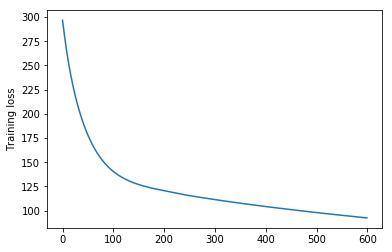

In [9]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
plotloss1=np.array(plotloss1)
plt.plot(plotloss1[0:epochs])
plt.ylabel('Training loss')
plt.show()

In [10]:
out,y_pred=forward_path(noHiddenLayers,x_test,W,b,Actfnvect)

In [11]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[1]):
    yvect.append(predict(y_pred[:,i]))
    y_trurevect.append(predict(y_test[:,i]))

# find accuracy
from sklearn.metrics import accuracy_score
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

0.8


In [12]:
# to see the output vs true values

print y_trurevect
print yvect

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[2, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [13]:
#MOMENTUM

In [14]:
###
################################
# Training parameters
num_classes = 3
epochs = 600
learning_rate=0.0001
batch_size = 10
alpha = 0.9
################################

#MLP PARAMETERS
noHiddenLayers=2

#also includes the input vector dimension and output vector dimension
sizeOfLayers=[x_train.shape[0],10,10,num_classes]

sizeofOutput=num_classes

Actfnvect = ['relu','relu','softmax']

In [15]:
np.random.seed(42)

W,b = weights(noHiddenLayers,sizeOfLayers)

In [16]:
# (a)
# Momentum descent

# updating the weights
plotloss2=[]


v = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

for i in range(epochs):
    loss=0
    for j in np.arange(0,x_train.shape[1],batch_size):       
        dW = np.zeros(W[0].shape)
        dM = np.zeros(W[1].shape)
        dT = np.zeros(W[2].shape)
        db1 = np.zeros(b[0].shape)
        db2 = np.zeros(b[1].shape)
        db3 = np.zeros(b[2].shape)
        for k in range(0,batch_size):
            # forward pass
            x = x_train[:,j+k].reshape(-1,1)
            y = y_train[:,j+k].reshape(-1,1)
            out,y_pred=forward_path(noHiddenLayers,x,W,b,Actfnvect)
            # backpropagation
            dWtemp,dMtemp,dTtemp,db1temp,db2temp,db3temp=backprop(y_pred,y,out[1],W[-1],out[0],W[1],x)
            
            dW=dW+dWtemp
            db1=db1+db1temp
            
            dM=dM+dMtemp
            db2=db2+db2temp
            
            dT=dT+dTtemp
            db3=db3+db3temp
        
            # calculate the loss
            loss = loss + (-1.0*np.sum(y*np.log(y_pred)))
            
        # Updating the weights using MOMENTUM Approach
        
        dW=dW*(1.0/batch_size)
        dM=dM*(1.0/batch_size)
        dT=dT*(1.0/batch_size)
        db1=db1*(1.0/batch_size)
        db2=db2*(1.0/batch_size)
        db3=db3*(1.0/batch_size)
        
        v["W[0]"] = alpha*v["W[0]"] - learning_rate*(dW)
        v["W[1]"] = alpha*v["W[1]"] - learning_rate*(dM)
        v["W[2]"] = alpha*v["W[2]"] - learning_rate*(dT)
        v["b[0]"] = alpha*v["b[0]"] - learning_rate*(db1)
        v["b[1]"] = alpha*v["b[1]"] - learning_rate*(db2)
        v["b[2]"] = alpha*v["b[2]"] - learning_rate*(db3)
        
        W[0] = W[0] + v["W[0]"]
        W[1] = W[1] + v["W[1]"]
        W[2] = W[2] + v["W[2]"]
        b[0] = b[0] + v["b[0]"]
        b[1] = b[1] + v["b[1]"]
        b[2] = b[2] + v["b[2]"]
        
    
    #print the loss in each epoch
    print('Epoch:'+str(i)+'         Loss:'+str(loss))
    plotloss2.append(loss)

Epoch:0         Loss:292.13349692258686
Epoch:1         Loss:264.9774564301665
Epoch:2         Loss:235.3337304782536
Epoch:3         Loss:211.1184615567953
Epoch:4         Loss:192.13943907155354
Epoch:5         Loss:177.3220093511113
Epoch:6         Loss:165.6834037633965
Epoch:7         Loss:156.50558075966634
Epoch:8         Loss:149.2382294372133
Epoch:9         Loss:143.4618736189342
Epoch:10         Loss:138.87832730981256
Epoch:11         Loss:135.21997810475054
Epoch:12         Loss:132.26356940050698
Epoch:13         Loss:129.84896460256914
Epoch:14         Loss:127.84672182645305
Epoch:15         Loss:126.16420023597792
Epoch:16         Loss:124.72246892562062
Epoch:17         Loss:123.46582921980445
Epoch:18         Loss:122.33492402055685
Epoch:19         Loss:121.2089855532333
Epoch:20         Loss:120.10967468899109
Epoch:21         Loss:118.9879585164047
Epoch:22         Loss:117.92911378345809
Epoch:23         Loss:116.97156631504386
Epoch:24         Loss:116.087926166

Epoch:213         Loss:52.63024964791883
Epoch:214         Loss:52.46029864249727
Epoch:215         Loss:52.29080532798795
Epoch:216         Loss:52.12168304446013
Epoch:217         Loss:51.953070772837115
Epoch:218         Loss:51.78415465656675
Epoch:219         Loss:51.617500139033375
Epoch:220         Loss:51.45135391139926
Epoch:221         Loss:51.2857918866497
Epoch:222         Loss:51.12062836326038
Epoch:223         Loss:50.955797675566494
Epoch:224         Loss:50.791449668851854
Epoch:225         Loss:50.627538111156575
Epoch:226         Loss:50.46383915131602
Epoch:227         Loss:50.29996956891737
Epoch:228         Loss:50.13625728631024
Epoch:229         Loss:49.97281741065459
Epoch:230         Loss:49.80968193629003
Epoch:231         Loss:49.64685651993915
Epoch:232         Loss:49.484339354662865
Epoch:233         Loss:49.322127014642874
Epoch:234         Loss:49.16007202560767
Epoch:235         Loss:48.9987142211019
Epoch:236         Loss:48.83805057135094
Epoch:237  

Epoch:414         Loss:28.063397079514996
Epoch:415         Loss:27.98467900164715
Epoch:416         Loss:27.906299348613715
Epoch:417         Loss:27.828255885416393
Epoch:418         Loss:27.750547042405618
Epoch:419         Loss:27.67317157220604
Epoch:420         Loss:27.596128353895804
Epoch:421         Loss:27.51941629936713
Epoch:422         Loss:27.44303431769421
Epoch:423         Loss:27.36698130703766
Epoch:424         Loss:27.291256156878518
Epoch:425         Loss:27.21585775246342
Epoch:426         Loss:27.140784978452285
Epoch:427         Loss:27.06603672115424
Epoch:428         Loss:26.991611869615987
Epoch:429         Loss:26.917509315997588
Epoch:430         Loss:26.843775277794528
Epoch:431         Loss:26.770289220832304
Epoch:432         Loss:26.697269938128183
Epoch:433         Loss:26.624605418821663
Epoch:434         Loss:26.552253099497023
Epoch:435         Loss:26.480116205633397
Epoch:436         Loss:26.408534202844102
Epoch:437         Loss:26.337157376774353

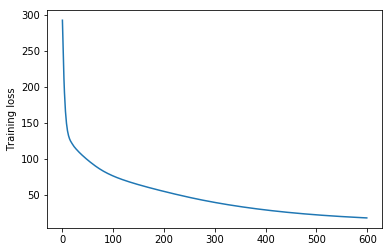

In [17]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
plotloss2=np.array(plotloss2)
plt.plot(plotloss2[0:epochs])
plt.ylabel('Training loss')
plt.show()

In [18]:
out,y_pred=forward_path(noHiddenLayers,x_test,W,b,Actfnvect)

In [19]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[1]):
    yvect.append(predict(y_pred[:,i]))
    y_trurevect.append(predict(y_test[:,i]))

# find accuracy
from sklearn.metrics import accuracy_score
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

1.0


In [20]:
# to see the output vs true values

print y_trurevect
print yvect

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [21]:
#NESTEROV MOMENTUM

In [22]:
###
################################
# Training parameters
num_classes = 3
epochs = 600
learning_rate=0.0001
batch_size = 10
alpha = 0.9
################################

#MLP PARAMETERS
noHiddenLayers=2

#also includes the input vector dimension and output vector dimension
sizeOfLayers=[x_train.shape[0],10,10,num_classes]

sizeofOutput=num_classes

Actfnvect = ['relu','relu','softmax']

In [23]:
np.random.seed(42)

W,b = weights(noHiddenLayers,sizeOfLayers)

In [24]:
# (a)
# NESTEROV momentum descent

# updating the weights

plotloss3=[]

v = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

for i in range(epochs):
    loss=0
    for j in np.arange(0,x_train.shape[1],batch_size):       
        dW = np.zeros(W[0].shape)
        dM = np.zeros(W[1].shape)
        dT = np.zeros(W[2].shape)
        db1 = np.zeros(b[0].shape)
        db2 = np.zeros(b[1].shape)
        db3 = np.zeros(b[2].shape)
        
        #Compute interim update
        W[0] = W[0] + alpha*v["W[0]"]
        W[1] = W[1] + alpha*v["W[1]"]
        W[2] = W[2] + alpha*v["W[2]"]
        b[0] = b[0] + alpha*v["b[0]"]
        b[1] = b[1] + alpha*v["b[1]"]
        b[2] = b[2] + alpha*v["b[2]"]
        
        for k in range(0,batch_size):
            # forward pass
            x = x_train[:,j+k].reshape(-1,1)
            y = y_train[:,j+k].reshape(-1,1)
            out,y_pred=forward_path(noHiddenLayers,x,W,b,Actfnvect)
            # backpropagation
            dWtemp,dMtemp,dTtemp,db1temp,db2temp,db3temp=backprop(y_pred,y,out[1],W[-1],out[0],W[1],x)
            
            dW=dW+dWtemp
            db1=db1+db1temp
            
            dM=dM+dMtemp
            db2=db2+db2temp
            
            dT=dT+dTtemp
            db3=db3+db3temp
        
            # calculate the loss
            loss = loss + (-1.0*np.sum(y*np.log(y_pred)))
            
        # Updating the weights using Nesterov MOMENTUM Approach
        
        dW=dW*(1.0/batch_size)
        dM=dM*(1.0/batch_size)
        dT=dT*(1.0/batch_size)
        db1=db1*(1.0/batch_size)
        db2=db2*(1.0/batch_size)
        db3=db3*(1.0/batch_size)
    
        #Compute velocity update
        v["W[0]"] = alpha*v["W[0]"] - learning_rate*(dW)
        v["W[1]"] = alpha*v["W[1]"] - learning_rate*(dM)
        v["W[2]"] = alpha*v["W[2]"] - learning_rate*(dT)
        v["b[0]"] = alpha*v["b[0]"] - learning_rate*(db1)
        v["b[1]"] = alpha*v["b[1]"] - learning_rate*(db2)
        v["b[2]"] = alpha*v["b[2]"] - learning_rate*(db3)
        
        #Apply update
        W[0] = W[0] + v["W[0]"]
        W[1] = W[1] + v["W[1]"]
        W[2] = W[2] + v["W[2]"]
        b[0] = b[0] + v["b[0]"]
        b[1] = b[1] + v["b[1]"]
        b[2] = b[2] + v["b[2]"]
        
    
    #print the loss in each epoch
    print('Epoch:'+str(i)+'         Loss:'+str(loss))
    plotloss3.append(loss)

Epoch:0         Loss:286.4075636371012
Epoch:1         Loss:239.98019247451055
Epoch:2         Loss:197.7443993810596
Epoch:3         Loss:169.12642191390916
Epoch:4         Loss:151.01369930482784
Epoch:5         Loss:139.75870731638867
Epoch:6         Loss:132.7563413311675
Epoch:7         Loss:128.24233862095477
Epoch:8         Loss:125.1442129801611
Epoch:9         Loss:122.77561515390481
Epoch:10         Loss:120.54977812029414
Epoch:11         Loss:118.51198389060924
Epoch:12         Loss:116.77543391891857
Epoch:13         Loss:115.19721409636843
Epoch:14         Loss:113.71106535952507
Epoch:15         Loss:112.28930455639978
Epoch:16         Loss:110.91161232029965
Epoch:17         Loss:109.58107323345527
Epoch:18         Loss:108.30565742623537
Epoch:19         Loss:107.05878530174303
Epoch:20         Loss:105.83556104136353
Epoch:21         Loss:104.63564402600585
Epoch:22         Loss:103.4514406917542
Epoch:23         Loss:102.28068822109633
Epoch:24         Loss:101.13037

Epoch:213         Loss:28.984397503177806
Epoch:214         Loss:28.827794479039223
Epoch:215         Loss:28.67238456344832
Epoch:216         Loss:28.518231214620773
Epoch:217         Loss:28.365477502856653
Epoch:218         Loss:28.21394555598629
Epoch:219         Loss:28.06359516913114
Epoch:220         Loss:27.91444214497338
Epoch:221         Loss:27.766503925825663
Epoch:222         Loss:27.61978358892491
Epoch:223         Loss:27.474273500327186
Epoch:224         Loss:27.329962474685082
Epoch:225         Loss:27.186839920664415
Epoch:226         Loss:27.04490444730619
Epoch:227         Loss:26.90430184233264
Epoch:228         Loss:26.764384464925143
Epoch:229         Loss:26.625931262053484
Epoch:230         Loss:26.48886990567067
Epoch:231         Loss:26.35246153943025
Epoch:232         Loss:26.217446680809864
Epoch:233         Loss:26.08377032300434
Epoch:234         Loss:25.950733098065935
Epoch:235         Loss:25.819060999570105
Epoch:236         Loss:25.688801122826508
Ep

Epoch:422         Loss:13.653836119269359
Epoch:423         Loss:13.626182220774146
Epoch:424         Loss:13.598872887851265
Epoch:425         Loss:13.571658125349888
Epoch:426         Loss:13.544722935890416
Epoch:427         Loss:13.517735909168607
Epoch:428         Loss:13.491153337047024
Epoch:429         Loss:13.464955412372936
Epoch:430         Loss:13.438444772725575
Epoch:431         Loss:13.412667617519807
Epoch:432         Loss:13.38660958449103
Epoch:433         Loss:13.361055778873112
Epoch:434         Loss:13.335412579539966
Epoch:435         Loss:13.31011760872474
Epoch:436         Loss:13.285157717752545
Epoch:437         Loss:13.259893989982352
Epoch:438         Loss:13.235357350643625
Epoch:439         Loss:13.21053767833758
Epoch:440         Loss:13.186206468580927
Epoch:441         Loss:13.161775598884633
Epoch:442         Loss:13.137678379686731
Epoch:443         Loss:13.113903156168467
Epoch:444         Loss:13.08978635204631
Epoch:445         Loss:13.066400826220

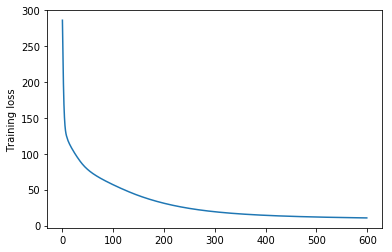

In [25]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
plotloss3=np.array(plotloss3)
plt.plot(plotloss3[0:epochs])
plt.ylabel('Training loss')
plt.show()

In [26]:
out,y_pred=forward_path(noHiddenLayers,x_test,W,b,Actfnvect)

In [27]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[1]):
    yvect.append(predict(y_pred[:,i]))
    y_trurevect.append(predict(y_test[:,i]))

# find accuracy
from sklearn.metrics import accuracy_score
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

0.9666666666666667


In [28]:
# to see the output vs true values

print y_trurevect
print yvect

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0]


In [29]:
#ADA GRAD
#####Note:run in python2######
# same initialization of weights because same random seed used

# Observations:
# for training deep neural network models, the accumulation of squared gradients from the beginning of
# training can result in a premature and excessive decrease in the eﬀective learning
# rate. AdaGrad performs well for some but not all deep learning models.
# When applied to a nonconvex function to train a neural network,
# the learning trajectory may pass through many diﬀerent structures and eventually
# arrive at a region that is a locally convex bowl. AdaGrad shrinks the learning rate
# according to the entire history of the squared gradient and may have made the
# learning rate too small before arriving at such a convex structure.


In [30]:
###
################################
# Training parameters
num_classes = 3
epochs = 600
batch_size = 10
learning_rate = 0.01
delta=1e-7
################################

#MLP PARAMETERS
noHiddenLayers=2

#also includes the input vector dimension and output vector dimension
sizeOfLayers=[x_train.shape[0],10,10,num_classes]

sizeofOutput=num_classes

Actfnvect = ['relu','relu','softmax']

In [31]:
np.random.seed(42)

W,b = weights(noHiddenLayers,sizeOfLayers)

In [32]:
# (a)
# adagrad descent

# updating the weights
plotloss4=[]


r = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

for i in range(epochs):
    loss=0
    for j in np.arange(0,x_train.shape[1],batch_size):       
        dW = np.zeros(W[0].shape)
        dM = np.zeros(W[1].shape)
        dT = np.zeros(W[2].shape)
        db1 = np.zeros(b[0].shape)
        db2 = np.zeros(b[1].shape)
        db3 = np.zeros(b[2].shape)
        for k in range(0,batch_size):
            # forward pass
            x = x_train[:,j+k].reshape(-1,1)
            y = y_train[:,j+k].reshape(-1,1)
            out,y_pred=forward_path(noHiddenLayers,x,W,b,Actfnvect)
            # backpropagation
            dWtemp,dMtemp,dTtemp,db1temp,db2temp,db3temp=backprop(y_pred,y,out[1],W[-1],out[0],W[1],x)
            
            dW=dW+dWtemp
            db1=db1+db1temp
            
            dM=dM+dMtemp
            db2=db2+db2temp
            
            dT=dT+dTtemp
            db3=db3+db3temp
        
            # calculate the loss
            loss = loss + (-1.0*np.sum(y*np.log(y_pred)))
            
        # Updating the weights using Adagrad Approach
        dW=dW*(1.0/batch_size)
        dM=dM*(1.0/batch_size)
        dT=dT*(1.0/batch_size)
        db1=db1*(1.0/batch_size)
        db2=db2*(1.0/batch_size)
        db3=db3*(1.0/batch_size)
        
        r["W[0]"] = r["W[0]"] + ((dW*dW))
        r["W[1]"] = r["W[1]"] + ((dM*dM))
        r["W[2]"] = r["W[2]"] + ((dT*dT))
        r["b[0]"] = r["b[0]"] + ((db1*db1))
        r["b[1]"] = r["b[1]"] + ((db2*db2))
        r["b[2]"] = r["b[2]"] + ((db3*db3))
        
        W[0] = W[0] - ( (learning_rate*dW)/(delta +np.sqrt(r["W[0]"])))
        W[1] = W[1] - ( (learning_rate*dM)/(delta +np.sqrt(r["W[1]"])))
        W[2] = W[2] - ( (learning_rate*dT)/(delta +np.sqrt(r["W[2]"])))
        b[0] = b[0] - ((learning_rate*db1)/(delta +np.sqrt(r["b[0]"])))
        b[1] = b[1] - ((learning_rate*db2)/(delta +np.sqrt(r["b[1]"])))
        b[2] = b[2] - ((learning_rate*db3)/(delta +np.sqrt(r["b[2]"])))
    
    #print the loss in each epoch
    print('Epoch:'+str(i)+'         Loss:'+str(loss))
    plotloss4.append(loss)

Epoch:0         Loss:209.06827590441537
Epoch:1         Loss:147.4171199130636
Epoch:2         Loss:124.32360273550304
Epoch:3         Loss:110.67707305969012
Epoch:4         Loss:100.89448902832505
Epoch:5         Loss:93.34340405542477
Epoch:6         Loss:87.26034146915657
Epoch:7         Loss:82.27160186124107
Epoch:8         Loss:78.12982118672839
Epoch:9         Loss:74.69610936983257
Epoch:10         Loss:71.80804924261979
Epoch:11         Loss:69.38857429685493
Epoch:12         Loss:67.34358281379204
Epoch:13         Loss:65.54004569094593
Epoch:14         Loss:63.94611904078274
Epoch:15         Loss:62.5248634288168
Epoch:16         Loss:61.25246325923568
Epoch:17         Loss:60.08003193371147
Epoch:18         Loss:58.971267797547206
Epoch:19         Loss:57.945237944291755
Epoch:20         Loss:56.98721312081335
Epoch:21         Loss:56.081205866043824
Epoch:22         Loss:55.21551536325608
Epoch:23         Loss:54.3839687490723
Epoch:24         Loss:53.59227977846066
Epoch

Epoch:203         Loss:16.200453177580936
Epoch:204         Loss:16.16053728942505
Epoch:205         Loss:16.12193001029298
Epoch:206         Loss:16.083141251918644
Epoch:207         Loss:16.044319506451004
Epoch:208         Loss:16.006772810880097
Epoch:209         Loss:15.968643618238925
Epoch:210         Loss:15.931369151345704
Epoch:211         Loss:15.894812689639323
Epoch:212         Loss:15.857702801009266
Epoch:213         Loss:15.821429520453774
Epoch:214         Loss:15.7858548644724
Epoch:215         Loss:15.749740614894922
Epoch:216         Loss:15.714436068681428
Epoch:217         Loss:15.679426706599887
Epoch:218         Loss:15.644718183412946
Epoch:219         Loss:15.6103112958969
Epoch:220         Loss:15.576204448410445
Epoch:221         Loss:15.542394874825204
Epoch:222         Loss:15.509287072249315
Epoch:223         Loss:15.475695276869534
Epoch:224         Loss:15.442836623217833
Epoch:225         Loss:15.410238854439577
Epoch:226         Loss:15.37790897075378

Epoch:401         Loss:12.14590091555272
Epoch:402         Loss:12.135205915936712
Epoch:403         Loss:12.124559960118361
Epoch:404         Loss:12.113962809816378
Epoch:405         Loss:12.103414184792843
Epoch:406         Loss:12.092913779746686
Epoch:407         Loss:12.08246127489498
Epoch:408         Loss:12.072056348457929
Epoch:409         Loss:12.061698662623701
Epoch:410         Loss:12.05138787870865
Epoch:411         Loss:12.041177331702961
Epoch:412         Loss:12.03097494179335
Epoch:413         Loss:12.020813263636116
Epoch:414         Loss:12.010693862419894
Epoch:415         Loss:12.000617620416921
Epoch:416         Loss:11.990587536988208
Epoch:417         Loss:11.980627282385814
Epoch:418         Loss:11.97070216747565
Epoch:419         Loss:11.960815161409624
Epoch:420         Loss:11.95096806815796
Epoch:421         Loss:11.941161936656437
Epoch:422         Loss:11.931397335269594
Epoch:423         Loss:11.921674513828155
Epoch:424         Loss:11.91199352097814

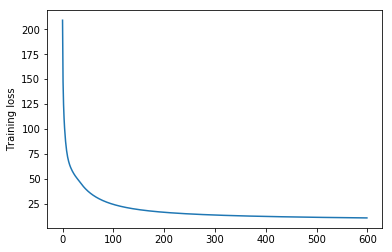

In [33]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
plotloss4=np.array(plotloss4)
plt.plot(plotloss4[0:epochs])
plt.ylabel('Training loss')
plt.show()

In [34]:
out,y_pred=forward_path(noHiddenLayers,x_test,W,b,Actfnvect)

In [35]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[1]):
    yvect.append(predict(y_pred[:,i]))
    y_trurevect.append(predict(y_test[:,i]))

# find accuracy
from sklearn.metrics import accuracy_score
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

1.0


In [36]:
# to see the output vs true values

print y_trurevect
print yvect

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [37]:
# RMS PROP
#####Note:run in python2######
# same initialization of weights because same random seed used

# OBSERVATIONS
# The RMSProp modiﬁes AdaGrad to perform better in the nonconvex setting by 
# changing the gradient accumulation into an exponentially weighted moving average.

# RMSProp uses an exponentially decaying average to discard history from the extreme past so that
# it can converge rapidly after ﬁnding a convex bowl, as if it were an instance of the
# AdaGrad algorithm initialized within that bowl

In [38]:
###
################################
# Training parameters
num_classes = 3
epochs = 600
rho=0.1
#1-rho=0.9
batch_size = 10
learning_rate = 1e-3
delta=1e-10
################################

#MLP PARAMETERS
noHiddenLayers=2

#also includes the input vector dimension and output vector dimension
sizeOfLayers=[x_train.shape[0],10,10,num_classes]

sizeofOutput=num_classes

Actfnvect = ['relu','relu','softmax']

In [39]:
np.random.seed(42)

W,b = weights(noHiddenLayers,sizeOfLayers)

In [40]:
# (a)
# RMS PROP descent

# updating the weights
plotloss5=[]


r = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

for i in range(epochs):
    loss=0
    for j in np.arange(0,x_train.shape[1],batch_size):       
        dW = np.zeros(W[0].shape)
        dM = np.zeros(W[1].shape)
        dT = np.zeros(W[2].shape)
        db1 = np.zeros(b[0].shape)
        db2 = np.zeros(b[1].shape)
        db3 = np.zeros(b[2].shape)
        for k in range(0,batch_size):
            # forward pass
            x = x_train[:,j+k].reshape(-1,1)
            y = y_train[:,j+k].reshape(-1,1)
            out,y_pred=forward_path(noHiddenLayers,x,W,b,Actfnvect)
            # backpropagation
            dWtemp,dMtemp,dTtemp,db1temp,db2temp,db3temp=backprop(y_pred,y,out[1],W[-1],out[0],W[1],x)
            
            dW=dW+dWtemp
            db1=db1+db1temp
            
            dM=dM+dMtemp
            db2=db2+db2temp
            
            dT=dT+dTtemp
            db3=db3+db3temp
        
            # calculate the loss
            loss = loss + (-1.0*np.sum(y*np.log(y_pred)))
            
        # Updating the weights using MOMENTUM Approach
        
        dW=dW*(1.0/batch_size)
        dM=dM*(1.0/batch_size)
        dT=dT*(1.0/batch_size)
        db1=db1*(1.0/batch_size)
        db2=db2*(1.0/batch_size)
        db3=db3*(1.0/batch_size)
        
        r["W[0]"] = (1-rho)*r["W[0]"] + (rho*(dW*dW))
        r["W[1]"] = (1-rho)*r["W[1]"] + (rho*(dM*dM))
        r["W[2]"] = (1-rho)*r["W[2]"] + (rho*(dT*dT))
        r["b[0]"] = (1-rho)*r["b[0]"] + (rho*(db1*db1))
        r["b[1]"] = (1-rho)*r["b[1]"] + (rho*(db2*db2))
        r["b[2]"] = (1-rho)*r["b[2]"] + (rho*(db3*db3))
        
        W[0] = W[0] - ((learning_rate*dW)/np.sqrt(delta +r["W[0]"]))
        W[1] = W[1] - ((learning_rate*dM)/np.sqrt(delta +r["W[1]"]))
        W[2] = W[2] - ((learning_rate*dT)/np.sqrt(delta +r["W[2]"]))
        b[0] = b[0] - ((learning_rate*db1)/np.sqrt(delta +r["b[0]"]))
        b[1] = b[1] - ((learning_rate*db2)/np.sqrt(delta +r["b[1]"]))
        b[2] = b[2] - ((learning_rate*db3)/np.sqrt(delta +r["b[2]"]))
    
    #print the loss in each epoch
    print('Epoch:'+str(i)+'         Loss:'+str(loss))
    plotloss5.append(loss)

Epoch:0         Loss:261.91179411693236
Epoch:1         Loss:221.99691595108465
Epoch:2         Loss:196.01410252452803
Epoch:3         Loss:175.18373879824532
Epoch:4         Loss:157.44626891354991
Epoch:5         Loss:142.50409954212125
Epoch:6         Loss:130.5297672314256
Epoch:7         Loss:121.0654461857608
Epoch:8         Loss:113.35049125181814
Epoch:9         Loss:106.6521145995553
Epoch:10         Loss:100.5413615204737
Epoch:11         Loss:94.81006512641092
Epoch:12         Loss:89.48901052305675
Epoch:13         Loss:84.62970113372056
Epoch:14         Loss:80.24999909997538
Epoch:15         Loss:76.41330601553412
Epoch:16         Loss:73.03978073338777
Epoch:17         Loss:70.04084902489588
Epoch:18         Loss:67.25611501395794
Epoch:19         Loss:64.6780175187461
Epoch:20         Loss:62.265796533548254
Epoch:21         Loss:60.04334374970081
Epoch:22         Loss:58.00116193975662
Epoch:23         Loss:56.09158148643866
Epoch:24         Loss:54.31398067177683
Epo

Epoch:204         Loss:9.68842152524058
Epoch:205         Loss:9.670729603245146
Epoch:206         Loss:9.653182419812783
Epoch:207         Loss:9.635908089003678
Epoch:208         Loss:9.618760215538817
Epoch:209         Loss:9.601831179347817
Epoch:210         Loss:9.585069700785992
Epoch:211         Loss:9.568499671045583
Epoch:212         Loss:9.552094986282723
Epoch:213         Loss:9.53588707801601
Epoch:214         Loss:9.519799174761033
Epoch:215         Loss:9.503945581258696
Epoch:216         Loss:9.488201247047607
Epoch:217         Loss:9.472648560308667
Epoch:218         Loss:9.457241776094241
Epoch:219         Loss:9.442013471563763
Epoch:220         Loss:9.427196607112155
Epoch:221         Loss:9.412313070731036
Epoch:222         Loss:9.397517678300773
Epoch:223         Loss:9.382927316949303
Epoch:224         Loss:9.368422578025415
Epoch:225         Loss:9.35411939353228
Epoch:226         Loss:9.339898068847146
Epoch:227         Loss:9.325873028111348
Epoch:228         L

Epoch:411         Loss:7.962024529222671
Epoch:412         Loss:7.958146800661283
Epoch:413         Loss:7.954289923722793
Epoch:414         Loss:7.950453751103834
Epoch:415         Loss:7.946638136911028
Epoch:416         Loss:7.942842936635089
Epoch:417         Loss:7.939068007131453
Epoch:418         Loss:7.9353132066023155
Epoch:419         Loss:7.931313770113682
Epoch:420         Loss:7.927571014326515
Epoch:421         Loss:7.923871884976247
Epoch:422         Loss:7.920196827070707
Epoch:423         Loss:7.916542135697522
Epoch:424         Loss:7.912906954025468
Epoch:425         Loss:7.90929099239462
Epoch:426         Loss:7.905694083660149
Epoch:427         Loss:7.9021160891682
Epoch:428         Loss:7.89855687776603
Epoch:429         Loss:7.895016320955878
Epoch:430         Loss:7.891494291748063
Epoch:431         Loss:7.887990664378741
Epoch:432         Loss:7.884505314232463
Epoch:433         Loss:7.881038117813237
Epoch:434         Loss:7.87758895272747
Epoch:435         Lo

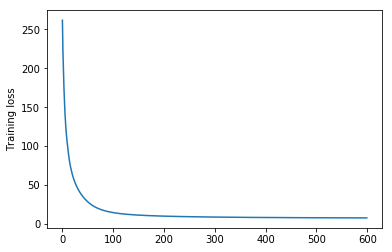

In [41]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
plotloss5=np.array(plotloss5)
plt.plot(plotloss5[0:epochs])
plt.ylabel('Training loss')
plt.show()

In [42]:
out,y_pred=forward_path(noHiddenLayers,x_test,W,b,Actfnvect)

In [43]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[1]):
    yvect.append(predict(y_pred[:,i]))
    y_trurevect.append(predict(y_test[:,i]))

# find accuracy
from sklearn.metrics import accuracy_score
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

1.0


In [44]:
# to see the output vs true values

print y_trurevect
print yvect

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


In [45]:
#ADAM

In [46]:
###
################################
# Training parameters
num_classes = 3
epochs = 600
rho1 = 0.9
rho2 = 0.99 
batch_size = 10
learning_rate = 1e-3
delta=1e-8
################################

#MLP PARAMETERS
noHiddenLayers=2

#also includes the input vector dimension and output vector dimension
sizeOfLayers=[x_train.shape[0],10,10,num_classes]

sizeofOutput=num_classes

Actfnvect = ['relu','relu','softmax']

In [47]:
np.random.seed(42)

W,b = weights(noHiddenLayers,sizeOfLayers)

In [48]:
#first moment
s = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

#second moment
r = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

#first moment Correct bias
sHat = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}

#second moment Correct bias
rHat = {"W[0]" : np.zeros(W[0].shape) , "W[1]" : np.zeros(W[1].shape) ,"W[2]" : np.zeros(W[2].shape),"b[0]": np.zeros(b[0].shape)
     ,"b[1]" :np.zeros(b[1].shape) , "b[2]" : np.zeros(b[2].shape)}
#time
t=0


In [49]:
# (a)
# ADAM descent

# updating the weights
plotloss6=[]


for i in range(epochs):
    loss=0
    for j in np.arange(0,x_train.shape[1],batch_size):       
        dW = np.zeros(W[0].shape)
        dM = np.zeros(W[1].shape)
        dT = np.zeros(W[2].shape)
        db1 = np.zeros(b[0].shape)
        db2 = np.zeros(b[1].shape)
        db3 = np.zeros(b[2].shape)
        
        for k in range(0,batch_size):
            # forward pass
            x = x_train[:,j+k].reshape(-1,1)
            y = y_train[:,j+k].reshape(-1,1)
            out,y_pred=forward_path(noHiddenLayers,x,W,b,Actfnvect)
            # backpropagation
            dWtemp,dMtemp,dTtemp,db1temp,db2temp,db3temp=backprop(y_pred,y,out[1],W[-1],out[0],W[1],x)
            
            dW=dW+dWtemp
            db1=db1+db1temp
            
            dM=dM+dMtemp
            db2=db2+db2temp
            
            dT=dT+dTtemp
            db3=db3+db3temp
        
            # calculate the loss
            loss = loss + (-1.0*np.sum(y*np.log(y_pred)))
            
        # Updating the weights using ADAM Approach
        
        #Normalising the weights as in deep learning text book
        dW=dW*(1.0/batch_size)
        dM=dM*(1.0/batch_size)
        dT=dT*(1.0/batch_size)
        db1=db1*(1.0/batch_size)
        db2=db2*(1.0/batch_size)
        db3=db3*(1.0/batch_size)
        
        #time update
        t=t+1
        
        #Update biased first moment estimate
        s["W[0]"] = rho1*s["W[0]"] + ((1.0-rho1)*(dW))
        s["W[1]"] = rho1*s["W[1]"] + ((1.0-rho1)*(dM))
        s["W[2]"] = rho1*s["W[2]"] + ((1.0-rho1)*(dT))
        s["b[0]"] = rho1*s["b[0]"] + ((1.0-rho1)*(db1))
        s["b[1]"] = rho1*s["b[1]"] + ((1.0-rho1)*(db2))
        s["b[2]"] = rho1*s["b[2]"] + ((1.0-rho1)*(db3))
        
        #Update biased second moment estimate
        r["W[0]"] = rho2*r["W[0]"] + ((1.0-rho2)*(dW*dW))
        r["W[1]"] = rho2*r["W[1]"] + ((1.0-rho2)*(dM*dM))
        r["W[2]"] = rho2*r["W[2]"] + ((1.0-rho2)*(dT*dT))
        r["b[0]"] = rho2*r["b[0]"] + ((1.0-rho2)*(db1*db1))
        r["b[1]"] = rho2*r["b[1]"] + ((1.0-rho2)*(db2*db2))
        r["b[2]"] = rho2*r["b[2]"] + ((1.0-rho2)*(db3*db3))
        
        #Correct bias in ﬁrst moment
        sHat["W[0]"] = (1.0/(1-(rho1**t)))*s["W[0]"] 
        sHat["W[1]"] = (1.0/(1-(rho1**t)))*s["W[1]"] 
        sHat["W[2]"] = (1.0/(1-(rho1**t)))*s["W[2]"] 
        sHat["b[0]"] = (1.0/(1-(rho1**t)))*s["b[0]"]
        sHat["b[1]"] = (1.0/(1-(rho1**t)))*s["b[1]"]
        sHat["b[2]"] = (1.0/(1-(rho1**t)))*s["b[2]"]
        
        #Correct bias in second moment
        rHat["W[0]"] = (1.0/(1-(rho2**t)))*r["W[0]"] 
        rHat["W[1]"] = (1.0/(1-(rho2**t)))*r["W[1]"] 
        rHat["W[2]"] = (1.0/(1-(rho2**t)))*r["W[2]"] 
        rHat["b[0]"] = (1.0/(1-(rho2**t)))*r["b[0]"]
        rHat["b[1]"] = (1.0/(1-(rho2**t)))*r["b[1]"]
        rHat["b[2]"] = (1.0/(1-(rho2**t)))*r["b[2]"]
        
        #Apply update
        W[0] = W[0] + (((-1.0*learning_rate)*sHat["W[0]"])/(np.sqrt(rHat["W[0]"])+delta))
        W[1] = W[1] + (((-1.0*learning_rate)*sHat["W[1]"])/(np.sqrt(rHat["W[1]"])+delta))
        W[2] = W[2] + (((-1.0*learning_rate)*sHat["W[2]"])/(np.sqrt(rHat["W[2]"])+delta))
        b[0] = b[0] + (((-1.0*learning_rate)*sHat["b[0]"])/(np.sqrt(rHat["b[0]"])+delta))
        b[1] = b[1] + (((-1.0*learning_rate)*sHat["b[1]"])/(np.sqrt(rHat["b[1]"])+delta))
        b[2] = b[2] + (((-1.0*learning_rate)*sHat["b[2]"])/(np.sqrt(rHat["b[2]"])+delta))
    
    #print the loss in each epoch
    print('Epoch:'+str(i)+'         Loss:'+str(loss))
    plotloss6.append(loss)

Epoch:0         Loss:279.6020777936365
Epoch:1         Loss:243.2263827738564
Epoch:2         Loss:213.52652592704587
Epoch:3         Loss:189.78718623277342
Epoch:4         Loss:170.71259807927697
Epoch:5         Loss:154.96787794018445
Epoch:6         Loss:141.56074642297185
Epoch:7         Loss:130.616206832028
Epoch:8         Loss:122.15984101343882
Epoch:9         Loss:115.19562934074774
Epoch:10         Loss:109.06752064111946
Epoch:11         Loss:103.45823509426738
Epoch:12         Loss:98.17318335611817
Epoch:13         Loss:93.158706197642
Epoch:14         Loss:88.44037840764275
Epoch:15         Loss:84.04681253542603
Epoch:16         Loss:80.00919342263205
Epoch:17         Loss:76.32223590954607
Epoch:18         Loss:73.02563159793336
Epoch:19         Loss:70.0701868698804
Epoch:20         Loss:67.42664620117002
Epoch:21         Loss:65.04905234434044
Epoch:22         Loss:62.929818146305955
Epoch:23         Loss:61.01995120765248
Epoch:24         Loss:59.26580780912478
Epoc

Epoch:211         Loss:9.162461590508736
Epoch:212         Loss:9.147729029255398
Epoch:213         Loss:9.133229656782497
Epoch:214         Loss:9.118825422857315
Epoch:215         Loss:9.104555949909527
Epoch:216         Loss:9.090434001495865
Epoch:217         Loss:9.076448417780316
Epoch:218         Loss:9.062587508431667
Epoch:219         Loss:9.048860042448547
Epoch:220         Loss:9.03526535976484
Epoch:221         Loss:9.021788679459497
Epoch:222         Loss:9.008456422632138
Epoch:223         Loss:8.995195630365055
Epoch:224         Loss:8.98212130299989
Epoch:225         Loss:8.969146691374535
Epoch:226         Loss:8.956248479666169
Epoch:227         Loss:8.943510478032952
Epoch:228         Loss:8.930875629497406
Epoch:229         Loss:8.91835738207298
Epoch:230         Loss:8.905910130992627
Epoch:231         Loss:8.893651421403607
Epoch:232         Loss:8.881420588600147
Epoch:233         Loss:8.869349022900998
Epoch:234         Loss:8.857347803762595
Epoch:235         L

Epoch:416         Loss:7.648269517305567
Epoch:417         Loss:7.6446797176202645
Epoch:418         Loss:7.641115179582281
Epoch:419         Loss:7.637564391680366
Epoch:420         Loss:7.63403437472778
Epoch:421         Loss:7.630523804905178
Epoch:422         Loss:7.627031611221999
Epoch:423         Loss:7.623557934441746
Epoch:424         Loss:7.620102937444243
Epoch:425         Loss:7.616666439675275
Epoch:426         Loss:7.613248226756788
Epoch:427         Loss:7.609848180331678
Epoch:428         Loss:7.6064662008343
Epoch:429         Loss:7.603100427976555
Epoch:430         Loss:7.599757307885989
Epoch:431         Loss:7.596427327457127
Epoch:432         Loss:7.5931163675258375
Epoch:433         Loss:7.589823260306508
Epoch:434         Loss:7.586547098480912
Epoch:435         Loss:7.583288002849795
Epoch:436         Loss:7.580046102555147
Epoch:437         Loss:7.576821234634448
Epoch:438         Loss:7.5736132097625335
Epoch:439         Loss:7.5704219204708885
Epoch:440      

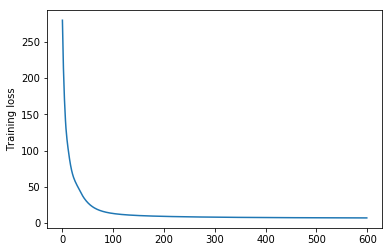

In [50]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
plotloss6=np.array(plotloss6)
plt.plot(plotloss6[0:epochs])
plt.ylabel('Training loss')
plt.show()

In [51]:
out,y_pred=forward_path(noHiddenLayers,x_test,W,b,Actfnvect)

In [52]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[1]):
    yvect.append(predict(y_pred[:,i]))
    y_trurevect.append(predict(y_test[:,i]))

# find accuracy
from sklearn.metrics import accuracy_score
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

1.0


In [53]:
# to see the output vs true values

print y_trurevect
print yvect

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]


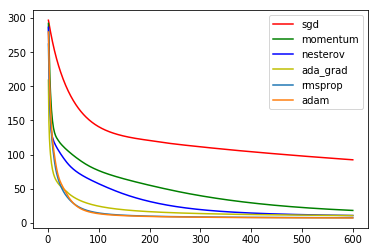

In [58]:
arr = np.arange(1,601)
plt.plot(arr,plotloss1,'r')
plt.plot(arr,plotloss2,'g')
plt.plot(arr,plotloss3,'b')
plt.plot(arr,plotloss4,'y')
plt.plot(arr,plotloss5)
plt.plot(arr,plotloss6)
plt.legend(['sgd','momentum','nesterov','ada_grad','rmsprop','adam'])
plt.show()